Import Libraries

In [18]:
import warnings, io, csv, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, cross_validate, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve,
                             precision_recall_curve, average_precision_score)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from joblib import dump

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Suppress warnings
warnings.filterwarnings("ignore")

# Set random state for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

Load and Prepare Data

This cell is modified to load your specific CSV and rename the columns to the standardized date and close that the rest of the script expects.

In [10]:
CSV_PATH = "../1 data acqusition/Antam_historical_gold_prices.csv"

try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"Error: File not found at {CSV_PATH}")
    df = pd.DataFrame() # Create empty dataframe to avoid further errors

if not df.empty:
    # --- Data Standardization ---
    # Rename your columns to the standard names used by the feature functions
    rename_map = {
        'Date': 'date',
        'Gold Price': 'close',
        'Time (ms)': 'time_ms' # Keep this column if you want, but we'll drop it later
    }
    df = df.rename(columns=rename_map)

    # Convert 'date' column to datetime objects
    df['date'] = pd.to_datetime(df['date'])
    
    # Sort by date, which is crucial for time-series features
    df = df.sort_values(by='date').reset_index(drop=True)
    
    # Select only the columns we need for the rest of the script
    df = df[['date', 'close']]

    print("--- Data Loaded and Standardized ---")
    print(f"Data shape: {df.shape}")
    print(df.head())
    print("\n")
    df.info()

--- Data Loaded and Standardized ---
Data shape: (4838, 2)
                 date   close
0 2010-01-04 09:07:00  408000
1 2010-01-05 09:28:00  410000
2 2010-01-06 07:01:00  410000
3 2010-01-07 09:45:00  412000
4 2010-01-08 09:37:00  410000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4838 entries, 0 to 4837
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4838 non-null   datetime64[ns]
 1   close   4838 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 75.7 KB


Exploratory Data Analysis (EDA)

Plot the price over time and the distribution of daily returns.

Date range: 2010-01-04 09:07:00 → 2025-10-07 08:02:15


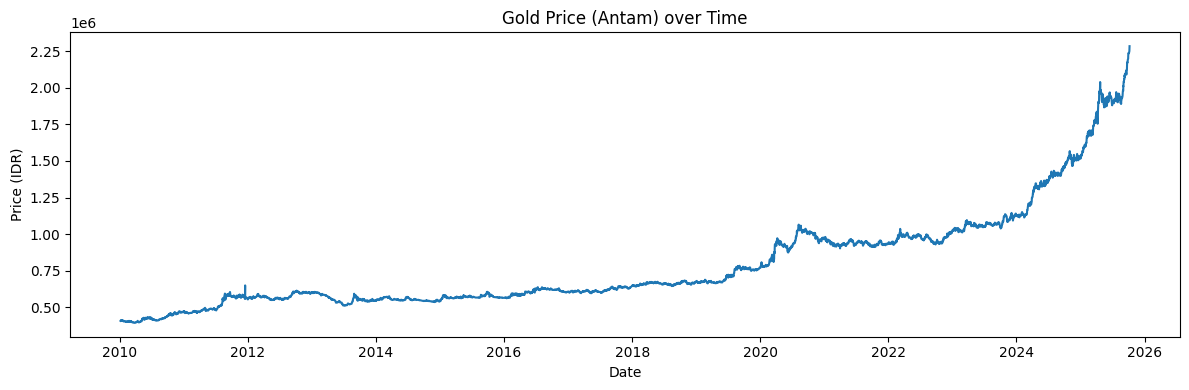

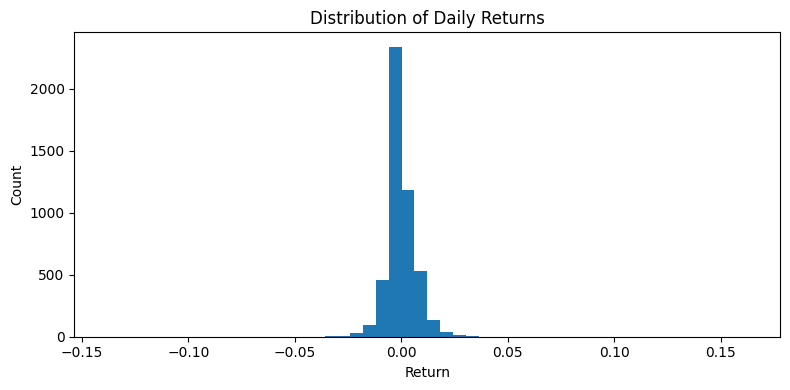

In [11]:
if not df.empty:
    print(f"Date range: {df['date'].min()} → {df['date'].max()}")

    # Plot price over time
    plt.figure(figsize=(12,4))
    plt.plot(df['date'], df['close'])
    plt.title("Gold Price (Antam) over Time")
    plt.xlabel("Date")
    plt.ylabel("Price (IDR)")
    plt.tight_layout()
    plt.savefig("gold_price_over_time.png")
    plt.show()

    # Calculate and plot returns
    df['ret'] = df['close'].pct_change()
    plt.figure(figsize=(8,4))
    plt.hist(df['ret'].dropna(), bins=50)
    plt.title("Distribution of Daily Returns")
    plt.xlabel("Return")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("gold_returns_distribution.png")
    plt.show()

Feature Engineering

This function (copied from your template) creates technical indicators (RSI, MACD, Bollinger Bands), rolling statistics, and calendar features.

In [19]:
def add_features_adaptive(data: pd.DataFrame, price='close') -> pd.DataFrame:
    out = data.copy()
    n = len(out)

    if n < 8:
        raise ValueError(f"Dataset too small after loading (n={n}). Add more rows.")

    out['ret'] = out[price].pct_change()
    out['log_ret'] = np.log1p(out['ret'])

    # Choose lags/windows based on data length
    max_lag = max(1, min(5, n // 6))
    lag_list = list(range(1, max_lag + 1))
    win_candidates = [3, 5, 10, 20]
    win_list = [w for w in win_candidates if w < n-2]
    if not win_list:
        win_list = [3]  # minimal

    for L in lag_list:
        out[f'ret_lag_{L}'] = out['ret'].shift(L)

    for w in win_list:
        out[f'roll_mean_{w}'] = out['ret'].rolling(w, min_periods=1).mean()
        out[f'roll_std_{w}']  = out['ret'].rolling(w, min_periods=1).std()
        out[f'roll_min_{w}']  = out['ret'].rolling(w, min_periods=1).min()
        out[f'roll_max_{w}']  = out['ret'].rolling(w, min_periods=1).max()

    # RSI with adaptive window
    rsi_w = max(3, min(14, n // 6))
    delta = out[price].diff()
    gain = (delta.where(delta > 0, 0.0)).rolling(rsi_w, min_periods=1).mean()
    loss = (-delta.where(delta < 0, 0.0)).rolling(rsi_w, min_periods=1).mean()
    rs = gain / (loss + 1e-9)
    out['rsi14'] = 100 - (100 / (1 + rs))

    # MACD (adaptive)
    fast = max(6, min(12, n // 5))
    slow = max(fast+4, min(26, n // 3))
    signal = max(5, min(9, n // 6))
    ema_fast = out[price].ewm(span=fast, adjust=False).mean()
    ema_slow = out[price].ewm(span=slow, adjust=False).mean()
    out['macd'] = ema_fast - ema_slow
    out['macd_signal'] = out['macd'].ewm(span=signal, adjust=False).mean()
    out['macd_hist'] = out['macd'] - out['macd_signal']

    # Bollinger (adaptive)
    bb_w = max(5, min(20, n // 4))
    ma = out[price].rolling(bb_w, min_periods=1).mean()
    sd = out[price].rolling(bb_w, min_periods=1).std()
    out['bb_mid'] = ma
    out['bb_up']  = ma + 2*sd
    out['bb_low'] = ma - 2*sd
    out['bb_width'] = (out['bb_up'] - out['bb_low']) / (out['bb_mid'] + 1e-9)

    # Calendar
    out['dow'] = out['date'].dt.weekday
    out['month'] = out['date'].dt.month

    return out

if not df.empty:
    feat = add_features_adaptive(df, price='close')

    # --- Target Creation (Classification) ---
    # Target = next-day direction (1 if Up, 0 if Down/Same)
    feat['next_close'] = feat['close'].shift(-1)
    feat['target'] = (feat['next_close'] > feat['close']).astype(int)

    # Drop rows with NaNs (from lags and target shift)
    feat = feat.dropna(subset=['target'] + [c for c in feat.columns if c.startswith('ret_lag_')]).reset_index(drop=True)

    # Define feature columns (X) and target (y)
    feature_cols = [c for c in feat.columns if c not in ['date','close','ret','log_ret','next_close','target']]
    X = feat[feature_cols]
    y = feat['target']

    print(f"Rows after features/dropna: {len(feat)} | Features: {len(feature_cols)}")
    print(f"First/last dates with features: {feat['date'].iloc[0]} → {feat['date'].iloc[-1]}")

Rows after features/dropna: 4832 | Features: 31
First/last dates with features: 2010-01-12 08:08:00 → 2025-10-07 08:02:15


In [20]:
if not X.empty:
    n = len(feat)
    # Ensure at least 5 samples in test set, or 20%
    test_size_n = max(5, int(n * 0.2))
    split_idx = n - test_size_n
    
    X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
    X_test,  y_test  = X.iloc[split_idx:], y.iloc[split_idx:]
    
    print(f"Train: {X_train.shape}  Test: {X_test.shape}")
    
    # TimeSeriesSplit for cross-validation within the training data
    max_splits = max(2, min(5, len(X_train) // 5))
    tscv = TimeSeriesSplit(n_splits=max_splits)
    print(f"TimeSeries CV splits: {tscv.n_splits}")

Train: (3866, 31)  Test: (966, 31)
TimeSeries CV splits: 5


In [7]:
if not df.empty:
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    print(f"--- Model Evaluation ---")
    print(f"R-squared (R²): {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:,.2f}")

--- Model Evaluation ---
R-squared (R²): 0.7259
Root Mean Squared Error (RMSE): 201,470.41


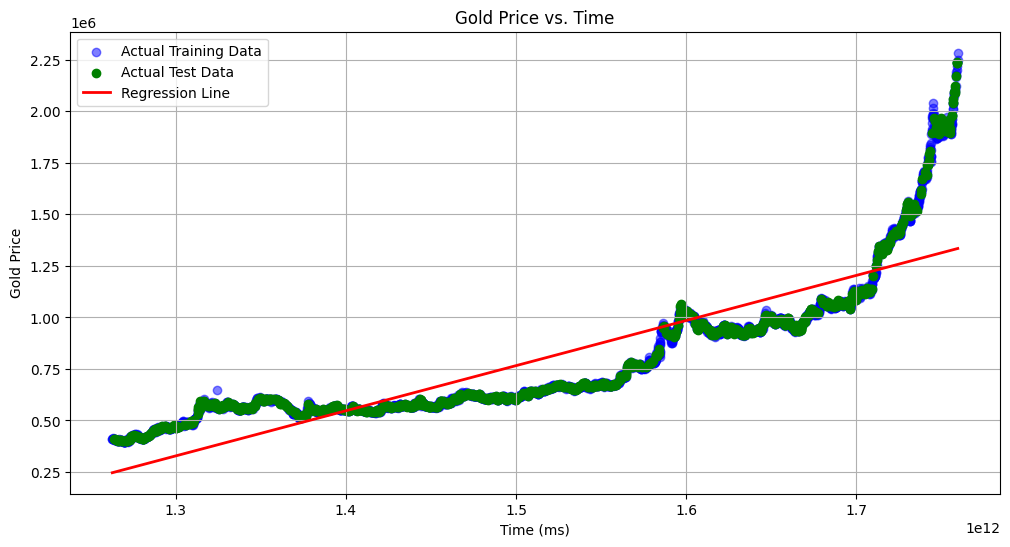

In [8]:
if not df.empty:
    plt.figure(figsize=(12, 6))
    
    # Plot the actual data points (training data)
    plt.scatter(X_train, y_train, color='blue', label='Actual Training Data', alpha=0.5)
    
    # Plot the actual data points (test data)
    plt.scatter(X_test, y_test, color='green', label='Actual Test Data')
    
    # Plot the regression line (using the full X range)
    # We plot against all of X to get the full line
    plt.plot(X, model.predict(X), color='red', linewidth=2, label='Regression Line')
    
    plt.title('Gold Price vs. Time')
    plt.xlabel('Time (ms)') # <-- Updated label
    plt.ylabel('Gold Price') # <-- Updated label
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
# Make sure datetime is imported (from Cell 1)
# import datetime as dt
import numpy as np

def predict_price_from_date(date_str, model_to_use):
    """
    Predicts the gold price for a given date string (e.g., "31-12-2025").
    Converts the date into a millisecond timestamp for the model.
    """
    try:
        # 1. Convert the date string to a datetime object
        date_obj = dt.datetime.strptime(date_str, "%d-%m-%Y")
        
        # 2. Convert to a millisecond timestamp
        # .timestamp() gives seconds, so multiply by 1000
        timestamp_ms = date_obj.timestamp() * 1000
        
        # 3. Reshape for the model
        timestamp_ms_2d = np.array([[timestamp_ms]])
        
        # 4. Make the prediction
        predicted_price = model_to_use.predict(timestamp_ms_2d)
        
        return f"Predicted price for {date_str}: Rp {predicted_price[0]:,.2f}"
        
    except ValueError:
        return "Invalid date format. Please use 'DD-MM-YYYY'."
    except NameError:
        return "Model not defined. Please run the training cell first."

# --- EXAMPLE PREDICTION ---
if 'model' in locals():
    prediction = predict_price_from_date("31-12-2025", model)
    print(prediction)
    
    prediction_2 = predict_price_from_date("01-06-2026", model)
    print(prediction_2)
else:
    print("Run the model training cells to make predictions.")

Predicted price for 31-12-2025: Rp 1,350,200.26
Predicted price for 01-06-2026: Rp 1,378,929.83


c:\Users\Gareth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Gareth\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
